# **Stacked ensemble network combining previously trained Emotion classifiers**


Code adapted from a multilabel classifier for the Kaggle Wine challange https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv("merged_a_d_e_all.csv", sep=',')
df.head()

,A_sadness,A_neutral,A_anger,A_fear,A_joy,D_anger,D_fear,D_joy,D_neutral,D_sadness,Emotion
0,-0.660100,3.330109,-1.251925,-2.181378,0.970935,0.120873,0.035028,0.097299,0.646314,0.100486,neutral
1,4.430455,-1.516692,-1.831247,-1.613842,-1.572614,0.235500,0.014428,0.002355,0.001166,0.746552,sadness
2,-0.654082,-0.279211,-0.169575,3.688235,-0.960192,0.814514,0.103679,0.005435,0.001215,0.075157,fear
3,-0.619089,-0.701786,-1.183047,4.495426,-0.520090,0.047783,0.922531,0.012216,0.001373,0.016098,fear
4,-1.082386,-1.405175,4.720406,-1.647028,-1.497529,0.975389,0.002286,0.000162,0.000016,0.022147,anger


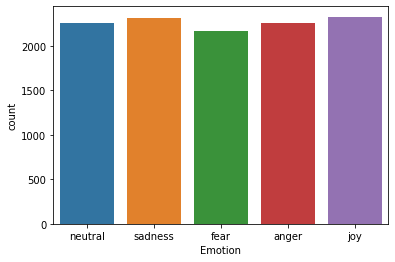

In [3]:
sns.countplot(x = 'Emotion', data=df)

In [4]:
class2idx = {
    'sadness':0,
    'neutral':1,
    'anger':2,
    'fear':3,
    'joy':4,
}

idx2class = {v: k for k, v in class2idx.items()}

df['Emotion'].replace(class2idx, inplace=True)

In [5]:
df.head()

,A_sadness,A_neutral,A_anger,A_fear,A_joy,D_anger,D_fear,D_joy,D_neutral,D_sadness,Emotion
0,-0.660100,3.330109,-1.251925,-2.181378,0.970935,0.120873,0.035028,0.097299,0.646314,0.100486,1
1,4.430455,-1.516692,-1.831247,-1.613842,-1.572614,0.235500,0.014428,0.002355,0.001166,0.746552,0
2,-0.654082,-0.279211,-0.169575,3.688235,-0.960192,0.814514,0.103679,0.005435,0.001215,0.075157,3
3,-0.619089,-0.701786,-1.183047,4.495426,-0.520090,0.047783,0.922531,0.012216,0.001373,0.016098,3
4,-1.082386,-1.405175,4.720406,-1.647028,-1.497529,0.975389,0.002286,0.000162,0.000016,0.022147,2


In [6]:
#we need to remove the data that was used to train the level 1 classifiers to prevent data seepage
df = df.iloc[7933: , :]

In [7]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [8]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=21)

In [9]:
'''# Split into train+val and test, using the same train set the constituant classifiers were trained on
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, train_size = 7933, shuffle = False)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)'''

'# Split into train+val and test, using the same train set the constituant classifiers were trained on\nX_trainval, X_test, y_trainval, y_test = train_test_split(X, y, train_size = 7933, shuffle = False)\n\n# Split train into train-val\nX_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)'

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [11]:
def get_class_distribution(obj):
    count_dict = {
        "sadness": 0,
        "neutral": 0,
        "anger": 0,
        "fear": 0,
        "joy": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['sadness'] += 1
        elif i == 1: 
            count_dict['neutral'] += 1
        elif i == 2: 
            count_dict['anger'] += 1
        elif i == 3: 
            count_dict['fear'] += 1
        elif i == 4: 
            count_dict['joy'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

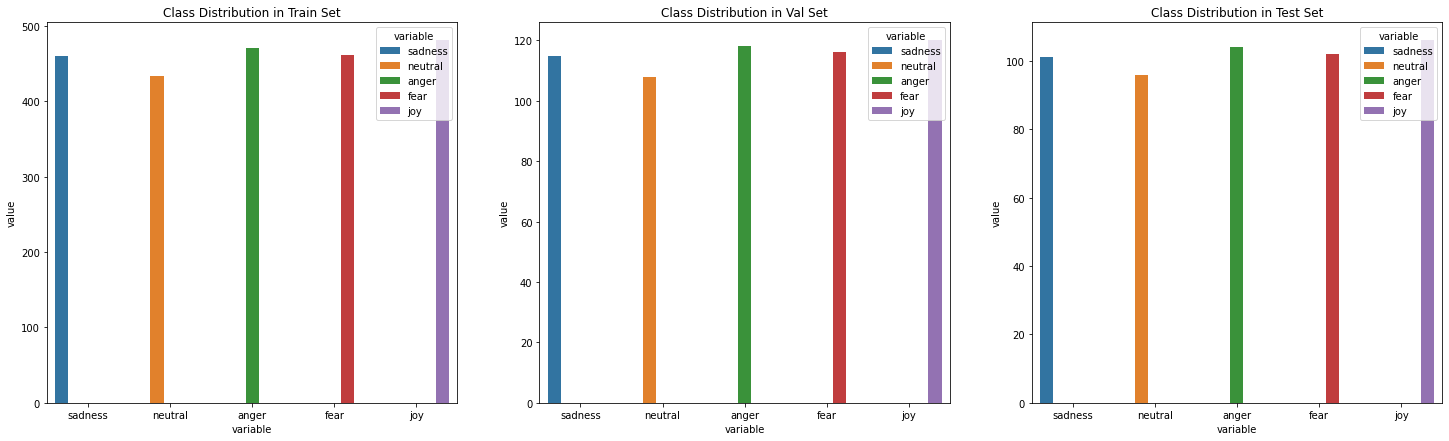

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [13]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [14]:
target_list = []

for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [15]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0022, 0.0023, 0.0021, 0.0022, 0.0021])


In [16]:
class_weights_all = class_weights[target_list]

In [17]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [18]:
EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.00001

NUM_FEATURES = len(X.columns)
NUM_CLASSES = 5

In [19]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [20]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=10, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [23]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [24]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [25]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


Epoch 001: | Train Loss: 1.50724 | Val Loss: 1.27404 | Train Acc: 32.883| Val Acc: 58.406
Epoch 002: | Train Loss: 1.25411 | Val Loss: 1.09974 | Train Acc: 57.876| Val Acc: 78.336
Epoch 003: | Train Loss: 1.11442 | Val Loss: 0.99507 | Train Acc: 68.766| Val Acc: 79.896
Epoch 004: | Train Loss: 1.02865 | Val Loss: 0.92226 | Train Acc: 73.524| Val Acc: 81.976
Epoch 005: | Train Loss: 0.99233 | Val Loss: 0.86484 | Train Acc: 74.434| Val Acc: 82.496
Epoch 006: | Train Loss: 0.92312 | Val Loss: 0.84967 | Train Acc: 77.041| Val Acc: 82.496
Epoch 007: | Train Loss: 0.91631 | Val Loss: 0.79239 | Train Acc: 76.800| Val Acc: 82.842
Epoch 008: | Train Loss: 0.86307 | Val Loss: 0.79280 | Train Acc: 78.566| Val Acc: 82.322
Epoch 009: | Train Loss: 0.85287 | Val Loss: 0.74722 | Train Acc: 77.407| Val Acc: 83.536
Epoch 010: | Train Loss: 0.80511 | Val Loss: 0.73573 | Train Acc: 81.172| Val Acc: 83.536
Epoch 011: | Train Loss: 0.82380 | Val Loss: 0.72469 | Train Acc: 79.090| Val Acc: 83.536
Epoch 012:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

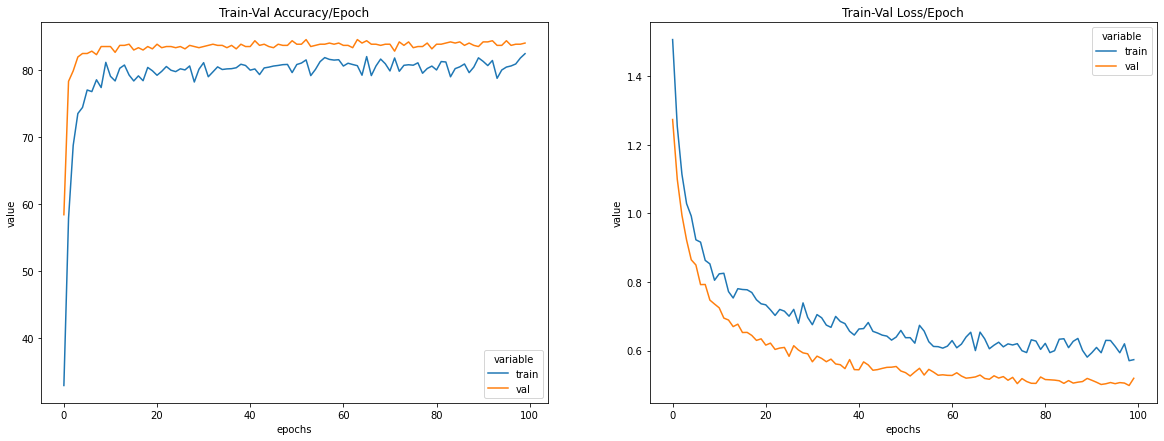

In [26]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [27]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

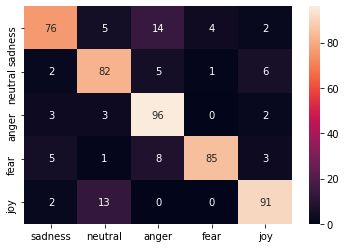

In [28]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [29]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       101
           1       0.79      0.85      0.82        96
           2       0.78      0.92      0.85       104
           3       0.94      0.83      0.89       102
           4       0.88      0.86      0.87       106

    accuracy                           0.84       509
   macro avg       0.85      0.84      0.84       509
weighted avg       0.85      0.84      0.84       509

